In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential, ICRS, Galactic, CylindricalRepresentation, CylindricalDifferential
from matplotlib.colors import Normalize
from galpy.util.coords import lbd_to_XYZ, XYZ_to_galcencyl
import warnings
from scipy.stats import binned_statistic


In [2]:
vetted_RGB = '../data/merged_data.fits'

with fits.open(vetted_RGB) as hdul:
    data = hdul[1].data  
    
    df_RGB = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
filtered = '../data/filtered_high_quality_sample.fits'

with fits.open(filtered) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df_filtered = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


In [4]:
pd.set_option('display.max_columns', None)
df_filtered.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,distance_pc
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.560006,-0.522061,696.278320
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.353831,-1.403210,1883.143550
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.398638,-0.339539,452.602692
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.329666,-1.404413,1868.603880
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.881068,-0.879697,1177.687260


In [5]:
# Extract relevant columns
l = df_filtered['l'].values  # Galactic longitude in degrees
b = df_filtered['b'].values  # Galactic latitude in degrees
rpgeo = df_filtered['rpgeo'].values  # Distance in parsecs

# Convert Galactic coordinates to Cartesian using galpy
xyz = lbd_to_XYZ(l, b, rpgeo, degree=True)
x, y, z = xyz.T 

# Transform to Galactocentric cylindrical coordinates
Xsun = 8.1  # Distance of the Sun from the Galactic Centre in kpc
Zsun = 0.025  # Sun's height above the midplane in kpc
R_phi_z = XYZ_to_galcencyl(x, y, z, Xsun=Xsun, Zsun=Zsun, _extra_rot=True)
R, phi, z_gal = R_phi_z.T  

# Add Galactocentric cylindrical coordinates to the DataFrame
df_filtered["R_gal"] = R
df_filtered["phi_gal"] = phi
df_filtered["Z_gal"] = z_gal

df_filtered.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,distance_pc,R_gal,phi_gal,Z_gal
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.560006,-0.522061,696.278320,470.404979,0.055741,-520.614770
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.353831,-1.403210,1883.143550,1268.278688,0.060775,-1399.311047
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.398638,-0.339539,452.602692,308.396557,0.064202,-338.591128
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.329666,-1.404413,1868.603880,1244.993992,0.073350,-1400.588965
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.881068,-0.879697,1177.687260,793.775983,0.072485,-877.258743


In [6]:
# Define the Sun's velocity with respect to the Galactic center
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km / u.s)

# Define the Galactocentric frame
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, 
                          z_sun=25 * u.pc, 
                          galcen_v_sun=v_sun)

In [7]:
# Extract the columns as numpy arrays
ra = df_filtered['ra'].values * u.deg
dec = df_filtered['dec'].values * u.deg
distance = df_filtered['rpgeo'].values * u.pc  
pmra = df_filtered['pmra'].values * u.mas / u.yr
pmdec = df_filtered['pmdec'].values * u.mas / u.yr
vlos = df_filtered['radial_velocity'].values * u.km / u.s

# Create a SkyCoord object for all sources at once
coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

# Transform all coordinates to the Galactocentric frame
cg = coords.transform_to(gc_frame)
cg.representation= 'cylindrical'

In [8]:
# Ensure cylindrical position and velocity representations
cg_cyl = cg.represent_as(CylindricalRepresentation)  # Cylindrical position (rho, phi, z)
cg_cyl_vel = cg.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']  # Cylindrical velocity

# Convert d_phi from rad/yr to rad/s
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)

# Convert rho from pc to km
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity in km/s)
v_phi_kms = -(d_phi_rad_s * rho_km)

df_filtered['v_phi'] = v_phi_kms.value

In [9]:
df_filtered['v_phi'].describe()

count    3.079600e+06
mean     1.996375e+02
std      5.374332e+01
min     -5.208987e+02
25%      1.814430e+02
50%      2.099946e+02
75%      2.321693e+02
max      4.768551e+02
Name: v_phi, dtype: float64

In [10]:
# Extract the columns as numpy arrays
ra = df_RGB['ra'].values * u.deg
dec = df_RGB['dec'].values * u.deg
distance = df_RGB['rpgeo'].values * u.pc  
pmra = df_RGB['pmra'].values * u.mas / u.yr
pmdec = df_RGB['pmdec'].values * u.mas / u.yr
vlos = df_RGB['radial_velocity'].values * u.km / u.s

# Create a SkyCoord object for all sources at once
coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

# Transform all coordinates to the Galactocentric frame
cg = coords.transform_to(gc_frame)
cg.representation= 'cylindrical'

# Ensure cylindrical position and velocity representations
cg_cyl = cg.represent_as(CylindricalRepresentation)  # Cylindrical position (rho, phi, z)
cg_cyl_vel = cg.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']  # Cylindrical velocity

# Convert d_phi from rad/yr to rad/s
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)

# Convert rho from pc to km
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity in km/s)
v_phi_kms = -(d_phi_rad_s * rho_km)

df_RGB['v_phi'] = v_phi_kms.value

In [11]:
df_RGB['v_phi'].describe()

count    1.257406e+07
mean     1.985908e+02
std      5.850558e+01
min     -6.072698e+02
25%      1.827798e+02
50%      2.120129e+02
75%      2.330824e+02
max      1.045464e+03
Name: v_phi, dtype: float64

In [12]:
data_array = np.array(
    list(df_filtered.itertuples(index=False, name=None)),
    dtype=[(col, df_filtered[col].dtype.type) for col in df_filtered.columns]
)

hdu = fits.BinTableHDU(data_array)

output_fits_filename = 'vphi_dataset.fits'
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")

FITS file saved as 'vphi_dataset.fits'


/var/folders/p3/pkt6pdhs7fq9ksxkhmbp2_xr0000gn/T/ipykernel_2690/413318929.py:21: RuntimeWarning: invalid value encountered in divide
  hist_max_normalised = hist / np.max(hist, axis=1, keepdims=True)



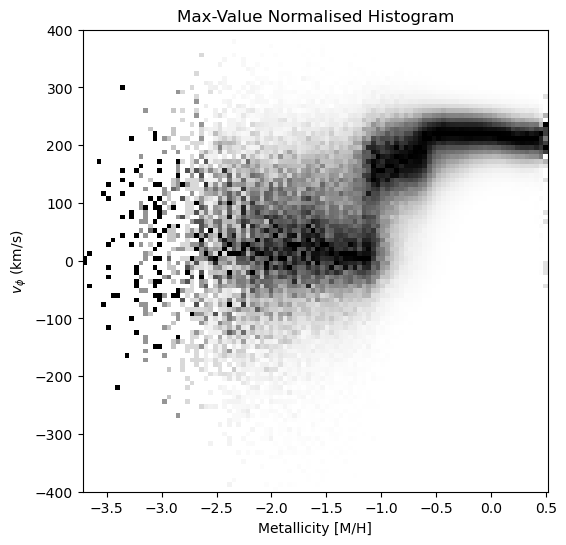

In [13]:
# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_filtered['mh_xgboost']
v_phi = df_filtered['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised = hist / np.max(hist, axis=1, keepdims=True)
hist_max_normalised[np.isnan(hist_max_normalised)] = 0 

# Plot the max-value normalised histogram
plt.figure(figsize=(6, 6))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=np.max(hist_max_normalised), clip=False)
)
plt.xlabel('Metallicity [M/H]')
plt.ylabel(r'$v_\phi$ (km/s)')
plt.title('Max-Value Normalised Histogram')

# Show plot
plt.show()


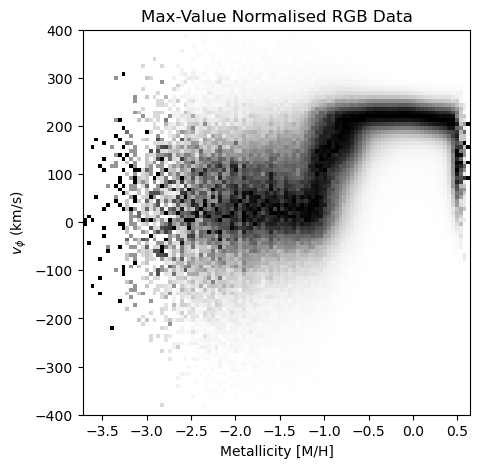

In [14]:
# Ensure no NaN values in the required columns
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_RGB['mh_xgboost']
v_phi = df_RGB['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised = hist / np.max(hist, axis=1, keepdims=True)
hist_max_normalised[np.isnan(hist_max_normalised)] = 0  

# Plot the max-value normalised histogram
plt.figure(figsize=(5, 5))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)

# Set axis labels and title
plt.xlabel('Metallicity [M/H]')
plt.ylabel(r'$v_\phi$ (km/s)')
plt.title('Max-Value Normalised RGB Data')
plt.ylim(-400, 400)

# Show plot
plt.show()


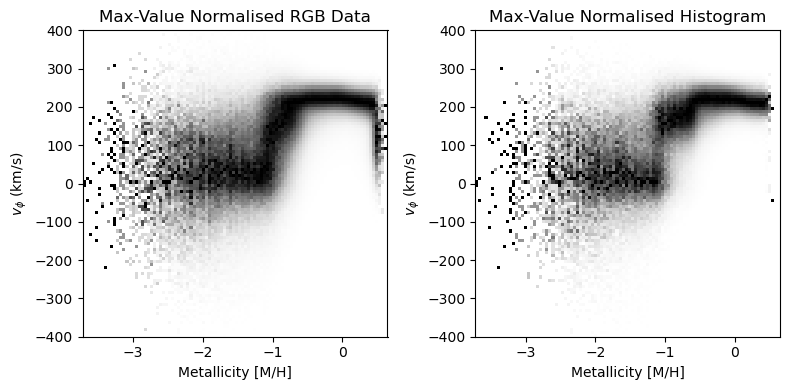

In [15]:
warnings.simplefilter("ignore", category=RuntimeWarning)

# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi for both datasets
metallicity_filtered = df_filtered['mh_xgboost']
v_phi_filtered = df_filtered['v_phi']
metallicity_RGB = df_RGB['mh_xgboost']
v_phi_RGB = df_RGB['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(min(metallicity_filtered.min(), metallicity_RGB.min()), 
                               max(metallicity_filtered.max(), metallicity_RGB.max()), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create 2D histograms for both datasets
hist_filtered, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity_filtered, v_phi_filtered, bins=[metallicity_bins, v_phi_bins]
)

hist_RGB, _, _ = np.histogram2d(
    metallicity_RGB, v_phi_RGB, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised_filtered = hist_filtered / np.max(hist_filtered, axis=1, keepdims=True)
hist_max_normalised_RGB = hist_RGB / np.max(hist_RGB, axis=1, keepdims=True)

# Avoid NaNs from zero division
hist_max_normalised_filtered[np.isnan(hist_max_normalised_filtered)] = 0
hist_max_normalised_RGB[np.isnan(hist_max_normalised_RGB)] = 0

# Create figure with 2 subplots (2 across, 1 down)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 3 across, 4 down per subplot

# Plot RGB data
ax1 = axes[0]
pcm1 = ax1.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised_RGB.T,
    cmap='Greys'
)
ax1.set_xlabel('Metallicity [M/H]')
ax1.set_ylabel(r'$v_\phi$ (km/s)')
ax1.set_title('Max-Value Normalised RGB Data')

# Plot filtered data
ax2 = axes[1]
pcm2 = ax2.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised_filtered.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)
ax2.set_xlabel('Metallicity [M/H]')
ax2.set_ylabel(r'$v_\phi$ (km/s)')
ax2.set_title('Max-Value Normalised Histogram')

# Adjust layout
plt.tight_layout()
plt.savefig('../figures/vphi_histograms.png', dpi=300)
plt.show()


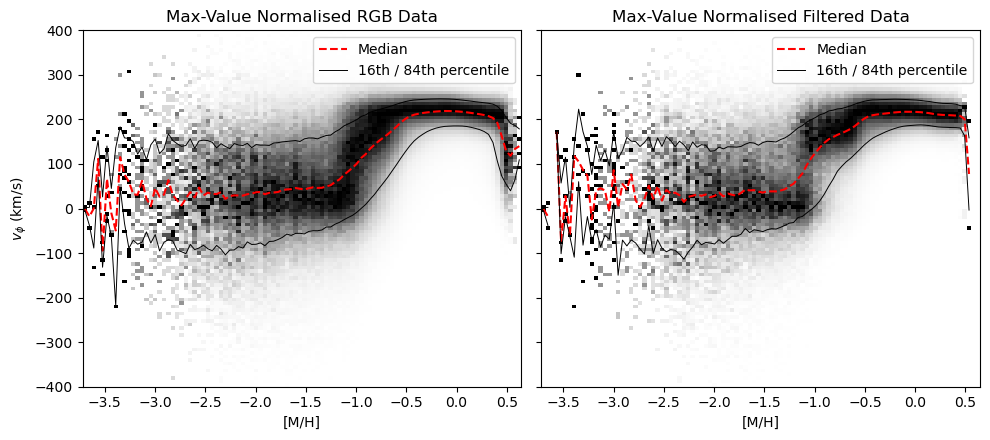

In [16]:
# Ignore runtime warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi for both datasets
metallicity_filtered = df_filtered['mh_xgboost']
v_phi_filtered = df_filtered['v_phi']
metallicity_RGB = df_RGB['mh_xgboost']
v_phi_RGB = df_RGB['v_phi']

# Define the number of bins
num_bins = 100
metallicity_bins = np.linspace(
    min(metallicity_filtered.min(), metallicity_RGB.min()), 
    max(metallicity_filtered.max(), metallicity_RGB.max()), 
    num_bins + 1
)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)
mh_centers = 0.5 * (metallicity_bins[:-1] + metallicity_bins[1:])

# Create 2D histograms
hist_filtered, _, _ = np.histogram2d(metallicity_filtered, v_phi_filtered, bins=[metallicity_bins, v_phi_bins])
hist_RGB, _, _ = np.histogram2d(metallicity_RGB, v_phi_RGB, bins=[metallicity_bins, v_phi_bins])

# Max-value column normalisation
hist_max_normalised_filtered = hist_filtered / np.max(hist_filtered, axis=1, keepdims=True)
hist_max_normalised_RGB = hist_RGB / np.max(hist_RGB, axis=1, keepdims=True)
hist_max_normalised_filtered[np.isnan(hist_max_normalised_filtered)] = 0
hist_max_normalised_RGB[np.isnan(hist_max_normalised_RGB)] = 0

# Compute running statistics
def compute_stats(mh, vphi, bins):
    med, _, _ = binned_statistic(mh, vphi, statistic='median', bins=bins)
    p16, _, _ = binned_statistic(mh, vphi, statistic=lambda x: np.percentile(x, 16), bins=bins)
    p84, _, _ = binned_statistic(mh, vphi, statistic=lambda x: np.percentile(x, 84), bins=bins)
    return med, p16, p84

med_rgb, p16_rgb, p84_rgb = compute_stats(metallicity_RGB, v_phi_RGB, metallicity_bins)
med_filtered, p16_filtered, p84_filtered = compute_stats(metallicity_filtered, v_phi_filtered, metallicity_bins)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

# Plot RGB
ax1 = axes[0]
pcm1 = ax1.pcolormesh(
    metallicity_bins, v_phi_bins, hist_max_normalised_RGB.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)
ax1.plot(mh_centers, med_rgb, 'r--', label='Median')
ax1.plot(mh_centers, p16_rgb, 'k-', linewidth=0.7, label='16th / 84th percentile')
ax1.plot(mh_centers, p84_rgb, 'k-', linewidth=0.7)
ax1.set_xlabel('[M/H]')
ax1.set_ylabel(r'$v_\phi$ (km/s)')
ax1.set_title('Max-Value Normalised RGB Data')
ax1.legend()

# Plot filtered
ax2 = axes[1]
pcm2 = ax2.pcolormesh(
    metallicity_bins, v_phi_bins, hist_max_normalised_filtered.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)
ax2.plot(mh_centers, med_filtered, 'r--', label='Median')
ax2.plot(mh_centers, p16_filtered, 'k-', linewidth=0.7, label='16th / 84th percentile')
ax2.plot(mh_centers, p84_filtered, 'k-', linewidth=0.7)
ax2.set_xlabel('[M/H]')
ax2.set_title('Max-Value Normalised Filtered Data')
ax2.legend()

# Final adjustments
plt.tight_layout()
plt.savefig('../figures/vphi_histograms_with_tracks.png', dpi=300)
plt.show()
